In [1]:
import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
def load_data(noise_u, noise_f):
    data = sio.loadmat("../dataset/Burgy.mat")
    x_u_train, t_u_train = data["x_u_train"], data["t_u_train"]
    x_f_train, t_f_train = data["x_f_train"], data["t_f_train"]
    x_test, t_test, u_test = data["x_test"], data["t_test"], data["u_test"]
    x_test, t_test, u_test = (
        x_test.reshape([-1, 1]),
        t_test.reshape([-1, 1]),
        u_test.reshape([-1, 1]),
    )
    u_train, f_train = data["u_train"], data["f_train"]
    train_u = x_u_train, t_u_train, u_train
    train_f = x_f_train, t_f_train, f_train
    test = x_test, t_test, u_test
    return train_u, train_f, test

In [3]:
def pde_fn(x, u, nu):
    u_x, u_t = tf.split(tf.gradients(u, x)[0], 2, axis=-1)
    u_xx = tf.gradients(u_x, x)[0][..., 0:1]
    
    f = u_t + u * u_x - tf.exp(nu) * u_xx
    # f = u_t + u * u_x - nu * u_xx
    
    # tf.exp(k_1) Computes exponential of k_1 element-wise (y = e^{k_1})
    # (KDV) f = u_t - tf.exp(k_1) * u * u_x - tf.exp(k_2) * u_xxx 
    ### DA CAPIRE LA STORIA DEL PERCHè PRENDE L'ESPONENZIALE DELLE VARIABILI
    return f

In [4]:
@neuq.utils.timer
def Samplable(
    x_u_train, t_u_train, u_train, x_f_train, t_f_train, f_train, noise, layers
):
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        prior=neuq_vars.fnn.Samplable(layers=layers, mean=0, sigma=1),
    )
    process_logk_1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=1),
    )
    
    # build likelihood
    likelihood_u = neuq.likelihoods.Normal(
        inputs=np.concatenate([x_u_train, t_u_train], axis=-1),
        targets=u_train,
        processes=[process_u],
        sigma=noise,
    )
    likelihood_f = neuq.likelihoods.Normal(
        inputs=np.concatenate([x_f_train, t_f_train], axis=-1),
        targets=f_train,
        processes=[process_u, process_logk_1],
        pde=pde_fn,
        sigma=noise,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_logk_1],
        likelihoods=[likelihood_u, likelihood_f],
    )
    # assign and compile method
    # Change the parameters to make the acceptance rate close to 0.6.
    method = neuq.inferences.HMC(
        num_samples=500,
        num_burnin=3000,
        init_time_step=0.01,
        leapfrog_step=50,
        seed=66,
    )
    model.compile(method)
    # obtain posterior samples
    samples, results = model.run()
    print("Acceptance rate: %.3f \n"%(np.mean(results)))

    processes = [process_u, process_logk_1]
    return processes, samples, model


In [5]:
@neuq.utils.timer
def Trainable(
    x_u_train, t_u_train, u_train, x_f_train, t_f_train, f_train, noise, layers
):
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        posterior=neuq_vars.fnn.Trainable(layers=layers),
    )
    process_logk_1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    
    loss_u = neuq.likelihoods.MSE(
        inputs=np.concatenate([x_u_train, t_u_train], axis=-1),
        targets=u_train,
        processes=[process_u],
        multiplier=1.0,
    )
    loss_f = neuq.likelihoods.MSE(
        inputs=np.concatenate([x_f_train, t_f_train], axis=-1),
        targets=f_train,
        processes=[process_u, process_logk_1],
        pde=pde_fn,
        multiplier=1.0,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_logk_1],
        likelihoods=[loss_u, loss_f],
    )
    # assign and compile method
    method = neuq.inferences.DEns(
        num_samples=20, num_iterations=20000, optimizer=tf.train.AdamOptimizer(1e-3),
    )
    model.compile(method)
    # obtain posterior samples
    samples = model.run()
    samples = neuq.utils.batch_samples(samples)  # reshape

    processes = [process_u, process_logk_1]
    return processes, samples, model

In [6]:
def plots(
    logk_1_pred,
    u_pred,
    x_test,
    t_test,
    u_test,
    x_u_train,
    t_u_train,
    u_train,
):
    ### DA CAPIRE LA STORIA DEL PERCHè PRENDE L'ESPONENZIALE DELLE VARIABILI
    
    k_1_pred = np.exp(logk_1_pred)
    #k_1_pred = logk_1_pred
    print("Mean & Std of k1 are %.3f, %.3f" % (np.mean(k_1_pred), np.std(k_1_pred)))
    
    u_pred = np.reshape(u_pred, [-1, NT, NX])
    mu = np.mean(u_pred, axis=0)
    std = np.std(u_pred, axis=0)
    
    x_test = np.reshape(x_test, [NT, NX])
    t_test = np.reshape(t_test, [NT, NX])
    u_test = np.reshape(u_test, [NT, NX])
    
    # cambiare i per avere plot su altri istanti di tempo
    # i = 0 --> first time instant
    i = 50
    
    current_t = t_test[i][0]
    # current_x*10 PERCHè PRIMA LA X è STATA NORMALIZZATA
    current_x = x_u_train[t_u_train == current_t]*10
    current_u = u_train[t_u_train == current_t]
    # std = np.sqrt(std**2 + 0.1**2)
    plt.plot(np.linspace(-10, 10, 300), mu[i, :], "--", label="mean")
    plt.fill_between(
        np.linspace(-10, 10, 300), (mu + 2 * std)[i, :], (mu - 2 * std)[i, :], alpha=0.3
    )
    plt.plot(np.linspace(-10, 10, 300), u_test[i, :], label="reference")
    plt.plot(current_x, current_u, "o", label="observations")
    plt.legend()
    plt.title("t=" + str(current_t))
    plt.show()

In [7]:
NT, NX = 60, 300
noise = 0.1
train_u, train_f, test = load_data(noise, noise)
x_u_train, t_u_train, u_train = train_u
x_f_train, t_f_train, f_train = train_f
x_test, t_test, u_test = test

layers = [2, 50, 50, 1]

In [8]:
processes_HMC, samples_HMC, model_HMC = Samplable(x_u_train, t_u_train, u_train, x_f_train, t_f_train, f_train, noise, layers,)

#processes, samples, model = Trainable(x_u_train, t_u_train, u_train, x_f_train, t_f_train, f_train, noise, layers,)

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.642 

Execution time for 'Samplable' function is: 116.412 s, 1.940 mins


Mean & Std of k1 are 0.430, 0.021


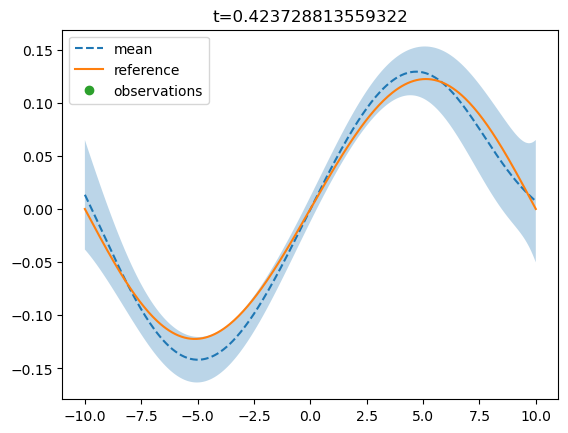

In [9]:
u_pred, logk_1_pred = model_HMC.predict(np.concatenate([x_test, t_test], axis=-1), samples_HMC, processes_HMC, pde_fn=None,)

plots(
    logk_1_pred,
    u_pred,
    x_test,
    t_test,
    u_test,
    x_u_train,
    t_u_train,
    u_train,
)

In [10]:
#processes, samples, model = Samplable(x_u_train, t_u_train, u_train, x_f_train, t_f_train, f_train, noise, layers,)

processes_DE, samples_DE, model_DE = Trainable(x_u_train, t_u_train, u_train, x_f_train, t_f_train, f_train, noise, layers,)

Supporting backend tensorflow.compat.v1

Compiling a Ensemble method

Generating 0th sample by deep ensemble...
Iteration:  0 , loss:  0.28318086
Iteration:  100 , loss:  0.06873497
Iteration:  200 , loss:  0.068127446
Iteration:  300 , loss:  0.06725807
Iteration:  400 , loss:  0.06597306
Iteration:  500 , loss:  0.06427949
Iteration:  600 , loss:  0.06222201
Iteration:  700 , loss:  0.05892375
Iteration:  800 , loss:  0.053428963
Iteration:  900 , loss:  0.045404367
Iteration:  1000 , loss:  0.035117585
Iteration:  1100 , loss:  0.025538372
Iteration:  1200 , loss:  0.017738435
Iteration:  1300 , loss:  0.014350378
Iteration:  1400 , loss:  0.012745319
Iteration:  1500 , loss:  0.011614445
Iteration:  1600 , loss:  0.010541402
Iteration:  1700 , loss:  0.00970538
Iteration:  1800 , loss:  0.0088222865
Iteration:  1900 , loss:  0.008207653
Iteration:  2000 , loss:  0.007577083
Iteration:  2100 , loss:  0.007056609
Iteration:  2200 , loss:  0.0065841503
Iteration:  2300 , loss:  0.0061

Iteration:  600 , loss:  0.03919168
Iteration:  700 , loss:  0.029598253
Iteration:  800 , loss:  0.021390058
Iteration:  900 , loss:  0.01590174
Iteration:  1000 , loss:  0.01196964
Iteration:  1100 , loss:  0.010175332
Iteration:  1200 , loss:  0.0089577865
Iteration:  1300 , loss:  0.00804661
Iteration:  1400 , loss:  0.00732942
Iteration:  1500 , loss:  0.0067329793
Iteration:  1600 , loss:  0.0075118463
Iteration:  1700 , loss:  0.0056099296
Iteration:  1800 , loss:  0.006546027
Iteration:  1900 , loss:  0.0047429083
Iteration:  2000 , loss:  0.0044019995
Iteration:  2100 , loss:  0.004106408
Iteration:  2200 , loss:  0.003829569
Iteration:  2300 , loss:  0.0035913126
Iteration:  2400 , loss:  0.0033956184
Iteration:  2500 , loss:  0.0032405816
Iteration:  2600 , loss:  0.0030906796
Iteration:  2700 , loss:  0.004291047
Iteration:  2800 , loss:  0.0028736803
Iteration:  2900 , loss:  0.0029122971
Iteration:  3000 , loss:  0.0027195546
Iteration:  3100 , loss:  0.0026579783
Iterati

Iteration:  1500 , loss:  0.006641112
Iteration:  1600 , loss:  0.006006846
Iteration:  1700 , loss:  0.005518931
Iteration:  1800 , loss:  0.0050717117
Iteration:  1900 , loss:  0.004714223
Iteration:  2000 , loss:  0.00442446
Iteration:  2100 , loss:  0.004220428
Iteration:  2200 , loss:  0.0044227205
Iteration:  2300 , loss:  0.0040280093
Iteration:  2400 , loss:  0.003715945
Iteration:  2500 , loss:  0.0035861274
Iteration:  2600 , loss:  0.0034825688
Iteration:  2700 , loss:  0.003390558
Iteration:  2800 , loss:  0.003347308
Iteration:  2900 , loss:  0.0033868896
Iteration:  3000 , loss:  0.0031434563
Iteration:  3100 , loss:  0.003091218
Iteration:  3200 , loss:  0.0030176667
Iteration:  3300 , loss:  0.0029210455
Iteration:  3400 , loss:  0.0028595622
Iteration:  3500 , loss:  0.0027867141
Iteration:  3600 , loss:  0.0027462295
Iteration:  3700 , loss:  0.0029152026
Iteration:  3800 , loss:  0.0026945323
Iteration:  3900 , loss:  0.0025418142
Iteration:  4000 , loss:  0.00270514

Iteration:  2400 , loss:  0.003764674
Iteration:  2500 , loss:  0.00353972
Iteration:  2600 , loss:  0.0033502984
Iteration:  2700 , loss:  0.0031797038
Iteration:  2800 , loss:  0.0030388774
Iteration:  2900 , loss:  0.0028991897
Iteration:  3000 , loss:  0.0027575977
Iteration:  3100 , loss:  0.0026431188
Iteration:  3200 , loss:  0.002510017
Iteration:  3300 , loss:  0.0024003363
Iteration:  3400 , loss:  0.0023161229
Iteration:  3500 , loss:  0.0022353977
Iteration:  3600 , loss:  0.0021709194
Iteration:  3700 , loss:  0.002103295
Iteration:  3800 , loss:  0.002038796
Iteration:  3900 , loss:  0.0019801622
Iteration:  4000 , loss:  0.0019147003
Iteration:  4100 , loss:  0.0018538795
Iteration:  4200 , loss:  0.0017885991
Iteration:  4300 , loss:  0.0017193584
Iteration:  4400 , loss:  0.0016563705
Iteration:  4500 , loss:  0.0015850666
Iteration:  4600 , loss:  0.001770175
Iteration:  4700 , loss:  0.0014346805
Iteration:  4800 , loss:  0.0013610655
Iteration:  4900 , loss:  0.0013

Iteration:  3000 , loss:  0.003744692
Iteration:  3100 , loss:  0.003649445
Iteration:  3200 , loss:  0.0034704567
Iteration:  3300 , loss:  0.0035585798
Iteration:  3400 , loss:  0.0037428834
Iteration:  3500 , loss:  0.003270782
Iteration:  3600 , loss:  0.0030127428
Iteration:  3700 , loss:  0.0029084715
Iteration:  3800 , loss:  0.00280454
Iteration:  3900 , loss:  0.0027011237
Iteration:  4000 , loss:  0.002599604
Iteration:  4100 , loss:  0.002567543
Iteration:  4200 , loss:  0.0023923528
Iteration:  4300 , loss:  0.0023772381
Iteration:  4400 , loss:  0.0021881955
Iteration:  4500 , loss:  0.002205519
Iteration:  4600 , loss:  0.0020169392
Iteration:  4700 , loss:  0.001980287
Iteration:  4800 , loss:  0.0019607306
Iteration:  4900 , loss:  0.0017542642
Iteration:  5000 , loss:  0.0016882474
Iteration:  5100 , loss:  0.0018023723
Iteration:  5200 , loss:  0.0015771091
Iteration:  5300 , loss:  0.0015295346
Iteration:  5400 , loss:  0.0014816488
Iteration:  5500 , loss:  0.001438

Iteration:  3900 , loss:  0.0018477376
Iteration:  4000 , loss:  0.0017808957
Iteration:  4100 , loss:  0.0017172826
Iteration:  4200 , loss:  0.001659673
Iteration:  4300 , loss:  0.001603273
Iteration:  4400 , loss:  0.001861414
Iteration:  4500 , loss:  0.0015018501
Iteration:  4600 , loss:  0.001464095
Iteration:  4700 , loss:  0.0014165451
Iteration:  4800 , loss:  0.0013800248
Iteration:  4900 , loss:  0.0014232463
Iteration:  5000 , loss:  0.0013078598
Iteration:  5100 , loss:  0.001283444
Iteration:  5200 , loss:  0.0012488032
Iteration:  5300 , loss:  0.0012517156
Iteration:  5400 , loss:  0.0012555316
Iteration:  5500 , loss:  0.0011762378
Iteration:  5600 , loss:  0.001151858
Iteration:  5700 , loss:  0.0011357082
Iteration:  5800 , loss:  0.001133948
Iteration:  5900 , loss:  0.001145483
Iteration:  6000 , loss:  0.0011240565
Iteration:  6100 , loss:  0.0010831896
Iteration:  6200 , loss:  0.0015047065
Iteration:  6300 , loss:  0.0010321083
Iteration:  6400 , loss:  0.00129

Iteration:  4800 , loss:  0.002102065
Iteration:  4900 , loss:  0.002033236
Iteration:  5000 , loss:  0.00197144
Iteration:  5100 , loss:  0.001988588
Iteration:  5200 , loss:  0.0019372744
Iteration:  5300 , loss:  0.0018187794
Iteration:  5400 , loss:  0.0018382394
Iteration:  5500 , loss:  0.0017390044
Iteration:  5600 , loss:  0.0017330518
Iteration:  5700 , loss:  0.0016707059
Iteration:  5800 , loss:  0.001636713
Iteration:  5900 , loss:  0.0016072477
Iteration:  6000 , loss:  0.0015760052
Iteration:  6100 , loss:  0.0015493836
Iteration:  6200 , loss:  0.0015198461
Iteration:  6300 , loss:  0.0015396958
Iteration:  6400 , loss:  0.0014643315
Iteration:  6500 , loss:  0.0014793391
Iteration:  6600 , loss:  0.0014111022
Iteration:  6700 , loss:  0.0013841256
Iteration:  6800 , loss:  0.0013588113
Iteration:  6900 , loss:  0.0013387075
Iteration:  7000 , loss:  0.0013083174
Iteration:  7100 , loss:  0.0013648805
Iteration:  7200 , loss:  0.0012593421
Iteration:  7300 , loss:  0.001

Iteration:  5700 , loss:  0.0018405202
Iteration:  5800 , loss:  0.0016698719
Iteration:  5900 , loss:  0.0016337082
Iteration:  6000 , loss:  0.001951732
Iteration:  6100 , loss:  0.0015857094
Iteration:  6200 , loss:  0.0015356047
Iteration:  6300 , loss:  0.001516984
Iteration:  6400 , loss:  0.0014756012
Iteration:  6500 , loss:  0.0016262035
Iteration:  6600 , loss:  0.0019345089
Iteration:  6700 , loss:  0.0013917532
Iteration:  6800 , loss:  0.0013647838
Iteration:  6900 , loss:  0.0020159371
Iteration:  7000 , loss:  0.001338447
Iteration:  7100 , loss:  0.0013300144
Iteration:  7200 , loss:  0.0012593982
Iteration:  7300 , loss:  0.0013859256
Iteration:  7400 , loss:  0.0012091033
Iteration:  7500 , loss:  0.00118821
Iteration:  7600 , loss:  0.001161376
Iteration:  7700 , loss:  0.0011403091
Iteration:  7800 , loss:  0.0011176093
Iteration:  7900 , loss:  0.0010970765
Iteration:  8000 , loss:  0.0010763458
Iteration:  8100 , loss:  0.0010580167
Iteration:  8200 , loss:  0.001

Iteration:  6500 , loss:  0.0005985166
Iteration:  6600 , loss:  0.00073777075
Iteration:  6700 , loss:  0.00057252863
Iteration:  6800 , loss:  0.0005936376
Iteration:  6900 , loss:  0.0005567749
Iteration:  7000 , loss:  0.0005423374
Iteration:  7100 , loss:  0.00053357106
Iteration:  7200 , loss:  0.0005380551
Iteration:  7300 , loss:  0.0005175374
Iteration:  7400 , loss:  0.0005122705
Iteration:  7500 , loss:  0.0005039703
Iteration:  7600 , loss:  0.0006234398
Iteration:  7700 , loss:  0.0006336452
Iteration:  7800 , loss:  0.0005595337
Iteration:  7900 , loss:  0.0004847339
Iteration:  8000 , loss:  0.0005066352
Iteration:  8100 , loss:  0.00048005328
Iteration:  8200 , loss:  0.0004643426
Iteration:  8300 , loss:  0.0004620927
Iteration:  8400 , loss:  0.00045532663
Iteration:  8500 , loss:  0.00049220334
Iteration:  8600 , loss:  0.0013504676
Iteration:  8700 , loss:  0.0004423751
Iteration:  8800 , loss:  0.0004988182
Iteration:  8900 , loss:  0.00043481332
Iteration:  9000 ,

Iteration:  7200 , loss:  0.001340121
Iteration:  7300 , loss:  0.0016837581
Iteration:  7400 , loss:  0.0012964504
Iteration:  7500 , loss:  0.0012756007
Iteration:  7600 , loss:  0.0012546169
Iteration:  7700 , loss:  0.0012527948
Iteration:  7800 , loss:  0.0012187192
Iteration:  7900 , loss:  0.0011990492
Iteration:  8000 , loss:  0.0012467147
Iteration:  8100 , loss:  0.0011664212
Iteration:  8200 , loss:  0.0011512672
Iteration:  8300 , loss:  0.0011352923
Iteration:  8400 , loss:  0.0011235576
Iteration:  8500 , loss:  0.0011070158
Iteration:  8600 , loss:  0.0010927098
Iteration:  8700 , loss:  0.0010812513
Iteration:  8800 , loss:  0.0012110719
Iteration:  8900 , loss:  0.00197076
Iteration:  9000 , loss:  0.0010417234
Iteration:  9100 , loss:  0.0015074643
Iteration:  9200 , loss:  0.0020982702
Iteration:  9300 , loss:  0.001006549
Iteration:  9400 , loss:  0.0010006254
Iteration:  9500 , loss:  0.0010042619
Iteration:  9600 , loss:  0.0010365426
Iteration:  9700 , loss:  0.0

Iteration:  8200 , loss:  0.0010906379
Iteration:  8300 , loss:  0.0010732108
Iteration:  8400 , loss:  0.0010558555
Iteration:  8500 , loss:  0.0010416736
Iteration:  8600 , loss:  0.0010239644
Iteration:  8700 , loss:  0.0010084396
Iteration:  8800 , loss:  0.0010094409
Iteration:  8900 , loss:  0.0009777278
Iteration:  9000 , loss:  0.0009672842
Iteration:  9100 , loss:  0.0009486431
Iteration:  9200 , loss:  0.00093590125
Iteration:  9300 , loss:  0.00092158176
Iteration:  9400 , loss:  0.0009231217
Iteration:  9500 , loss:  0.00089539756
Iteration:  9600 , loss:  0.0008815981
Iteration:  9700 , loss:  0.00086954003
Iteration:  9800 , loss:  0.00086582644
Iteration:  9900 , loss:  0.001195729
Iteration:  10000 , loss:  0.0008317779
Iteration:  10100 , loss:  0.0017471488
Iteration:  10200 , loss:  0.00080746977
Iteration:  10300 , loss:  0.00083102495
Iteration:  10400 , loss:  0.00078358816
Iteration:  10500 , loss:  0.00077523955
Iteration:  10600 , loss:  0.00095190975
Iteration

Iteration:  9000 , loss:  0.00086993026
Iteration:  9100 , loss:  0.0007613221
Iteration:  9200 , loss:  0.0007914225
Iteration:  9300 , loss:  0.0007465645
Iteration:  9400 , loss:  0.0007323762
Iteration:  9500 , loss:  0.0013213562
Iteration:  9600 , loss:  0.000714338
Iteration:  9700 , loss:  0.0007078535
Iteration:  9800 , loss:  0.0006976528
Iteration:  9900 , loss:  0.0007344588
Iteration:  10000 , loss:  0.0006819329
Iteration:  10100 , loss:  0.00067640434
Iteration:  10200 , loss:  0.0006673259
Iteration:  10300 , loss:  0.00066064694
Iteration:  10400 , loss:  0.0006552241
Iteration:  10500 , loss:  0.0006539128
Iteration:  10600 , loss:  0.0006587239
Iteration:  10700 , loss:  0.0018465107
Iteration:  10800 , loss:  0.0006270679
Iteration:  10900 , loss:  0.00062225916
Iteration:  11000 , loss:  0.0006150515
Iteration:  11100 , loss:  0.00060871145
Iteration:  11200 , loss:  0.00060307427
Iteration:  11300 , loss:  0.00062190637
Iteration:  11400 , loss:  0.0006097788
Iter

Iteration:  9800 , loss:  0.00049426267
Iteration:  9900 , loss:  0.00048821606
Iteration:  10000 , loss:  0.00049438456
Iteration:  10100 , loss:  0.0007012673
Iteration:  10200 , loss:  0.00076481036
Iteration:  10300 , loss:  0.00054033205
Iteration:  10400 , loss:  0.00047551768
Iteration:  10500 , loss:  0.00050325575
Iteration:  10600 , loss:  0.00073960033
Iteration:  10700 , loss:  0.00044961378
Iteration:  10800 , loss:  0.00044791718
Iteration:  10900 , loss:  0.00044475327
Iteration:  11000 , loss:  0.00045250863
Iteration:  11100 , loss:  0.0008633763
Iteration:  11200 , loss:  0.0004355182
Iteration:  11300 , loss:  0.00046404198
Iteration:  11400 , loss:  0.0004308206
Iteration:  11500 , loss:  0.0005296944
Iteration:  11600 , loss:  0.00042676614
Iteration:  11700 , loss:  0.0004953254
Iteration:  11800 , loss:  0.0004228805
Iteration:  11900 , loss:  0.0004337653
Iteration:  12000 , loss:  0.00042097777
Iteration:  12100 , loss:  0.0008772431
Iteration:  12200 , loss:  

Iteration:  10600 , loss:  0.0006490421
Iteration:  10700 , loss:  0.0005379723
Iteration:  10800 , loss:  0.00053157227
Iteration:  10900 , loss:  0.00053987966
Iteration:  11000 , loss:  0.00053235894
Iteration:  11100 , loss:  0.00053143076
Iteration:  11200 , loss:  0.00053124863
Iteration:  11300 , loss:  0.000631811
Iteration:  11400 , loss:  0.00051565986
Iteration:  11500 , loss:  0.00053621025
Iteration:  11600 , loss:  0.00051151373
Iteration:  11700 , loss:  0.0005088368
Iteration:  11800 , loss:  0.00050642266
Iteration:  11900 , loss:  0.001135275
Iteration:  12000 , loss:  0.0005023431
Iteration:  12100 , loss:  0.0005013929
Iteration:  12200 , loss:  0.0006701782
Iteration:  12300 , loss:  0.0004965034
Iteration:  12400 , loss:  0.0004962658
Iteration:  12500 , loss:  0.00049529865
Iteration:  12600 , loss:  0.0004912051
Iteration:  12700 , loss:  0.0005018463
Iteration:  12800 , loss:  0.0004957329
Iteration:  12900 , loss:  0.00048627736
Iteration:  13000 , loss:  0.00

Iteration:  11200 , loss:  0.00064771454
Iteration:  11300 , loss:  0.0005278393
Iteration:  11400 , loss:  0.00043348095
Iteration:  11500 , loss:  0.0005399461
Iteration:  11600 , loss:  0.0004276216
Iteration:  11700 , loss:  0.00042696233
Iteration:  11800 , loss:  0.00042292004
Iteration:  11900 , loss:  0.0007519448
Iteration:  12000 , loss:  0.00042046967
Iteration:  12100 , loss:  0.00043137016
Iteration:  12200 , loss:  0.00041281924
Iteration:  12300 , loss:  0.00041072688
Iteration:  12400 , loss:  0.00041476166
Iteration:  12500 , loss:  0.00043836134
Iteration:  12600 , loss:  0.00041430676
Iteration:  12700 , loss:  0.00040910632
Iteration:  12800 , loss:  0.00040335045
Iteration:  12900 , loss:  0.00039985692
Iteration:  13000 , loss:  0.00039764427
Iteration:  13100 , loss:  0.00039926567
Iteration:  13200 , loss:  0.000404172
Iteration:  13300 , loss:  0.00071062957
Iteration:  13400 , loss:  0.00039547583
Iteration:  13500 , loss:  0.0004098177
Iteration:  13600 , los

Iteration:  11800 , loss:  0.0005625673
Iteration:  11900 , loss:  0.00064376404
Iteration:  12000 , loss:  0.00054759625
Iteration:  12100 , loss:  0.0005591636
Iteration:  12200 , loss:  0.0005381348
Iteration:  12300 , loss:  0.0005334801
Iteration:  12400 , loss:  0.00053774245
Iteration:  12500 , loss:  0.00052492094
Iteration:  12600 , loss:  0.0007646322
Iteration:  12700 , loss:  0.0005164597
Iteration:  12800 , loss:  0.00052245945
Iteration:  12900 , loss:  0.00050883944
Iteration:  13000 , loss:  0.0005057762
Iteration:  13100 , loss:  0.0005038864
Iteration:  13200 , loss:  0.00049890165
Iteration:  13300 , loss:  0.0004954336
Iteration:  13400 , loss:  0.0004936989
Iteration:  13500 , loss:  0.0007776813
Iteration:  13600 , loss:  0.00048657536
Iteration:  13700 , loss:  0.00048618074
Iteration:  13800 , loss:  0.0005123809
Iteration:  13900 , loss:  0.00047856744
Iteration:  14000 , loss:  0.00047759654
Iteration:  14100 , loss:  0.00047430364
Iteration:  14200 , loss:  0

Iteration:  12600 , loss:  0.00047869675
Iteration:  12700 , loss:  0.00045418955
Iteration:  12800 , loss:  0.00045674865
Iteration:  12900 , loss:  0.00045220018
Iteration:  13000 , loss:  0.00045005005
Iteration:  13100 , loss:  0.00045443216
Iteration:  13200 , loss:  0.0005346123
Iteration:  13300 , loss:  0.00058086705
Iteration:  13400 , loss:  0.00044485775
Iteration:  13500 , loss:  0.00045617908
Iteration:  13600 , loss:  0.0004430723
Iteration:  13700 , loss:  0.00044216352
Iteration:  13800 , loss:  0.0007815621
Iteration:  13900 , loss:  0.00043957017
Iteration:  14000 , loss:  0.0007769504
Iteration:  14100 , loss:  0.0004375696
Iteration:  14200 , loss:  0.0004380224
Iteration:  14300 , loss:  0.0004974564
Iteration:  14400 , loss:  0.00043489982
Iteration:  14500 , loss:  0.00049673
Iteration:  14600 , loss:  0.0004513168
Iteration:  14700 , loss:  0.0010160354
Iteration:  14800 , loss:  0.00043156624
Iteration:  14900 , loss:  0.0006346406
Iteration:  15000 , loss:  0.

Iteration:  13300 , loss:  0.0003991156
Iteration:  13400 , loss:  0.00042755442
Iteration:  13500 , loss:  0.00039484125
Iteration:  13600 , loss:  0.0003925198
Iteration:  13700 , loss:  0.000395464
Iteration:  13800 , loss:  0.000860569
Iteration:  13900 , loss:  0.0003865621
Iteration:  14000 , loss:  0.00040039173
Iteration:  14100 , loss:  0.00038286796
Iteration:  14200 , loss:  0.000382527
Iteration:  14300 , loss:  0.0003793575
Iteration:  14400 , loss:  0.00038103625
Iteration:  14500 , loss:  0.00037607545
Iteration:  14600 , loss:  0.0004269715
Iteration:  14700 , loss:  0.00037283232
Iteration:  14800 , loss:  0.0003810568
Iteration:  14900 , loss:  0.00036984147
Iteration:  15000 , loss:  0.00045063283
Iteration:  15100 , loss:  0.0003668557
Iteration:  15200 , loss:  0.0003691719
Iteration:  15300 , loss:  0.00036404017
Iteration:  15400 , loss:  0.0005288236
Iteration:  15500 , loss:  0.00036133517
Iteration:  15600 , loss:  0.00035986985
Iteration:  15700 , loss:  0.00

Iteration:  14100 , loss:  0.0005142157
Iteration:  14200 , loss:  0.0005107705
Iteration:  14300 , loss:  0.00051676127
Iteration:  14400 , loss:  0.0005079046
Iteration:  14500 , loss:  0.0005066012
Iteration:  14600 , loss:  0.00050783897
Iteration:  14700 , loss:  0.0007580947
Iteration:  14800 , loss:  0.00058289414
Iteration:  14900 , loss:  0.00050085515
Iteration:  15000 , loss:  0.0004996191
Iteration:  15100 , loss:  0.000505261
Iteration:  15200 , loss:  0.0023600894
Iteration:  15300 , loss:  0.00049556955
Iteration:  15400 , loss:  0.0005995293
Iteration:  15500 , loss:  0.0013737183
Iteration:  15600 , loss:  0.0004916657
Iteration:  15700 , loss:  0.00049525633
Iteration:  15800 , loss:  0.0004891171
Iteration:  15900 , loss:  0.00048965646
Iteration:  16000 , loss:  0.00048865256
Iteration:  16100 , loss:  0.00048571636
Iteration:  16200 , loss:  0.00048412438
Iteration:  16300 , loss:  0.00048472872
Iteration:  16400 , loss:  0.00048974255
Iteration:  16500 , loss:  0.

Iteration:  14800 , loss:  0.0005232461
Iteration:  14900 , loss:  0.00052114035
Iteration:  15000 , loss:  0.0005789561
Iteration:  15100 , loss:  0.00052592554
Iteration:  15200 , loss:  0.0005303303
Iteration:  15300 , loss:  0.00050863443
Iteration:  15400 , loss:  0.00050644955
Iteration:  15500 , loss:  0.0005046244
Iteration:  15600 , loss:  0.0005024456
Iteration:  15700 , loss:  0.000519818
Iteration:  15800 , loss:  0.0005008179
Iteration:  15900 , loss:  0.00052144425
Iteration:  16000 , loss:  0.00066209387
Iteration:  16100 , loss:  0.0006114645
Iteration:  16200 , loss:  0.00048818014
Iteration:  16300 , loss:  0.00051344436
Iteration:  16400 , loss:  0.00057452684
Iteration:  16500 , loss:  0.0009022588
Iteration:  16600 , loss:  0.00047912681
Iteration:  16700 , loss:  0.00047816595
Iteration:  16800 , loss:  0.00047543977
Iteration:  16900 , loss:  0.000472674
Iteration:  17000 , loss:  0.00047091328
Iteration:  17100 , loss:  0.00047702514
Iteration:  17200 , loss:  0

Mean & Std of k1 are 0.500, 0.005


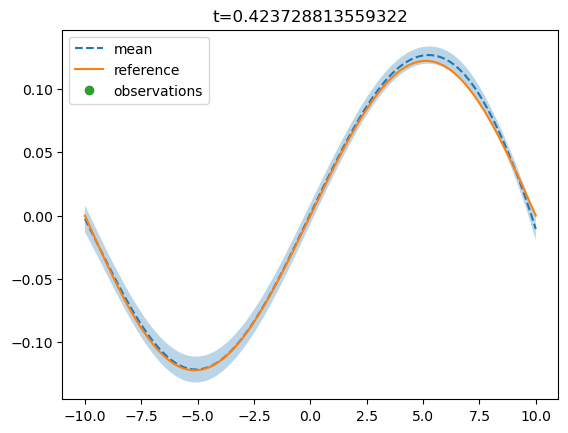

In [11]:
u_pred, logk_1_pred = model_DE.predict(np.concatenate([x_test, t_test], axis=-1), samples_DE, processes_DE, pde_fn=None,)
plots(
    logk_1_pred,
    u_pred,
    x_test,
    t_test,
    u_test,
    x_u_train,
    t_u_train,
    u_train,
)